### Importing Libraries

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

### Pre-processing - Training and Testing sets

In [ ]:
# Set dataset path
base_dir = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20               # Initial training epochs
LR = 1e-4
NUM_CLASSES = 4           # e.g., vasc, nv, df, bkl

# 2. DATA GENERATORS (NO EXTRA AUGMENTATION)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print the mapping to verify (example: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3})
print("Class indices:", train_generator.class_indices)

# Define class weights to give, for example, 'bkl' (assumed index 0) higher importance.
class_weight = {0: 1.5, 1: 1.0, 2: 1.0, 3: 1.0}

### Building the VGG16 Model
Model Structure:
- **Base Model:** VGG16 (Pretrained on ImageNet, Excludes Fully Connected Layers)
  - Conv Block 1: 2 Conv Layers → MaxPooling
  - Conv Block 2: 2 Conv Layers → MaxPooling
  - Conv Block 3: 3 Conv Layers → MaxPooling
  - Conv Block 4: 3 Conv Layers → MaxPooling
  - Conv Block 5: 3 Conv Layers → MaxPooling
  - Output: Feature maps from final convolutional layer

- **Custom Classification Head:**
  - Global Average Pooling Layer (Reduces feature maps to a single 1D vector)
  - Fully Connected Layer (1024 neurons, ReLU activation, L2 regularization)
  - Dropout Layer (60% dropout to reduce overfitting)
  - Output Layer (Softmax activation for multi-class classification)

- **Training Phases:**
  - **Phase 1 (Feature Extraction):** Freeze all VGG16 layers, train only the classification head.
  - **Phase 2 (Fine-Tuning):** Unfreeze last convolutional block (block5_), update selected layers with a lower learning rate.


In [ ]:
# Load VGG16 with ImageNet weights (excluding the fully connected top layers)
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3))

#Freeze the base model layers to retain pretrained features during initial training
for layer in base_model.layers:
    layer.trainable = False

#Add a custom classification head with added regularization to reduce overfitting
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a 1D feature vector
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)  #Fully connected layer with L2 regularization
x = Dropout(0.6)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

#Define the complete model combining VGG16 and the custom head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model for the initial training phase
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

#############################
# TRAINING - PHASE 1 WITH CLASS WEIGHTS
#############################

# Save the best model during training based on validation accuracy
checkpoint = ModelCheckpoint('best_model_vgg16_phase1.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Stop training early if validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           restore_best_weights=True)

# Combine callbacks for training
callbacks_list = [checkpoint, early_stop]

# Train the model using class weights to handle class imbalance
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,  # Apply early stopping and model checkpointing
    class_weight=class_weight  # Adjust class importance during training
)

#############################
# 5. FINE-TUNING (PHASE 2)
#############################

# Unfreeze only the last convolutional block ('block5_') for fine-tuning
for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True

# Recompile the model with a lower learning rate to fine-tune the last layers
model.compile(
    optimizer=Adam(learning_rate=1e-5),  #Lower LR prevents drastic weight updates
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save the best fine-tuned model based on validation accuracy
checkpoint_ft = ModelCheckpoint('best_model_vgg16_finetune.h5',
                                monitor='val_accuracy',
                                save_best_only=True,
                                mode='max',
                                verbose=1)

# Early stopping for fine-tuning phase
early_stop_ft = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                              restore_best_weights=True)

# Combine fine-tuning callbacks
callbacks_list_ft = [checkpoint_ft, early_stop_ft]

# Continue training for fine-tuning with a few additional epochs
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=10,  #Additional fine-tuning epochs
    callbacks=callbacks_list_ft,
    class_weight=class_weight  # Apply class weights during fine-tuning as well
)


### Evaluation Metrics - Performance of the Model

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4241 - loss: 2.6148 
Epoch 1: val_accuracy improved from -inf to 0.65125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1363s 14s/step - accuracy: 0.4252 - loss: 2.6080 - val_accuracy: 0.6513 - val_loss: 0.9600
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7056 - loss: 1.0985
Epoch 2: val_accuracy improved from 0.65125 to 0.75000, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 319ms/step - accuracy: 0.7058 - loss: 1.0977 - val_accuracy: 0.7500 - val_loss: 0.7099
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7798 - loss: 0.8344
Epoch 3: val_accuracy improved from 0.75000 to 0.78000, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.7799 - loss: 0.8341 - val_accuracy: 0.7800 - val_loss: 0.6783
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8245 - loss: 0.6417
Epoch 4: val_accuracy improved from 0.78000 to 0.80750, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - accuracy: 0.8245 - loss: 0.6415 - val_accuracy: 0.8075 - val_loss: 0.6041
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8485 - loss: 0.5552
Epoch 5: val_accuracy improved from 0.80750 to 0.82750, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.8485 - loss: 0.5551 - val_accuracy: 0.8275 - val_loss: 0.5739
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8705 - loss: 0.4535
Epoch 6: val_accuracy improved from 0.82750 to 0.83000, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.8705 - loss: 0.4538 - val_accuracy: 0.8300 - val_loss: 0.5705
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8955 - loss: 0.4096
Epoch 7: val_accuracy did not improve from 0.83000
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - accuracy: 0.8954 - loss: 0.4098 - val_accuracy: 0.8250 - val_loss: 0.5260
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8879 - loss: 0.4107
Epoch 8: val_accuracy did not improve from 0.83000
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - accuracy: 0.8879 - loss: 0.4105 - val_accuracy: 0.8275 - val_loss: 0.5029
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9001 - loss: 0.3862
Epoch 9: val_accuracy improved from 0.83000 to 0.83500, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.9002 - loss: 0.3861 - val_accuracy: 0.8350 - val_loss: 0.4970
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9114 - loss: 0.3502
Epoch 10: val_accuracy did not improve from 0.83500
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 306ms/step - accuracy: 0.9114 - loss: 0.3502 - val_accuracy: 0.8225 - val_loss: 0.5100
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9126 - loss: 0.3306
Epoch 11: val_accuracy did not improve from 0.83500
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 301ms/step - accuracy: 0.9127 - loss: 0.3305 - val_accuracy: 0.8225 - val_loss: 0.5032
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9324 - loss: 0.2803
Epoch 12: val_accuracy did not improve from 0.83500
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.9323 - loss: 0.2804 - val_accuracy: 0.8238 - val_loss: 0.4882
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9262 - loss: 0.3048
Epoch 13

100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 332ms/step - accuracy: 0.9406 - loss: 0.2704 - val_accuracy: 0.8537 - val_loss: 0.4288
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9594 - loss: 0.1908
Epoch 2: val_accuracy improved from 0.85375 to 0.85625, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 318ms/step - accuracy: 0.9594 - loss: 0.1908 - val_accuracy: 0.8562 - val_loss: 0.4231
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9741 - loss: 0.1649
Epoch 3: val_accuracy did not improve from 0.85625
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.9741 - loss: 0.1650 - val_accuracy: 0.8562 - val_loss: 0.4329
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9761 - loss: 0.1447
Epoch 4: val_accuracy improved from 0.85625 to 0.85875, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 356ms/step - accuracy: 0.9761 - loss: 0.1447 - val_accuracy: 0.8587 - val_loss: 0.4163
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9825 - loss: 0.1262
Epoch 5: val_accuracy improved from 0.85875 to 0.88375, saving model to best_model_vgg16_finetune.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - accuracy: 0.9825 - loss: 0.1262 - val_accuracy: 0.8838 - val_loss: 0.3619
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9890 - loss: 0.1075
Epoch 6: val_accuracy did not improve from 0.88375
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.9890 - loss: 0.1075 - val_accuracy: 0.8487 - val_loss: 0.4872
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9892 - loss: 0.1064
Epoch 7: val_accuracy did not improve from 0.88375
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy: 0.9892 - loss: 0.1064 - val_accuracy: 0.8800 - val_loss: 0.3810
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9937 - loss: 0.0933
Epoch 8: val_accuracy did not improve from 0.88375
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - accuracy: 0.9937 - loss: 0.0933 - val_accuracy: 0.8275 - val_loss: 0.5072
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9947 - loss: 0.0901
Epoch 9: val_ac

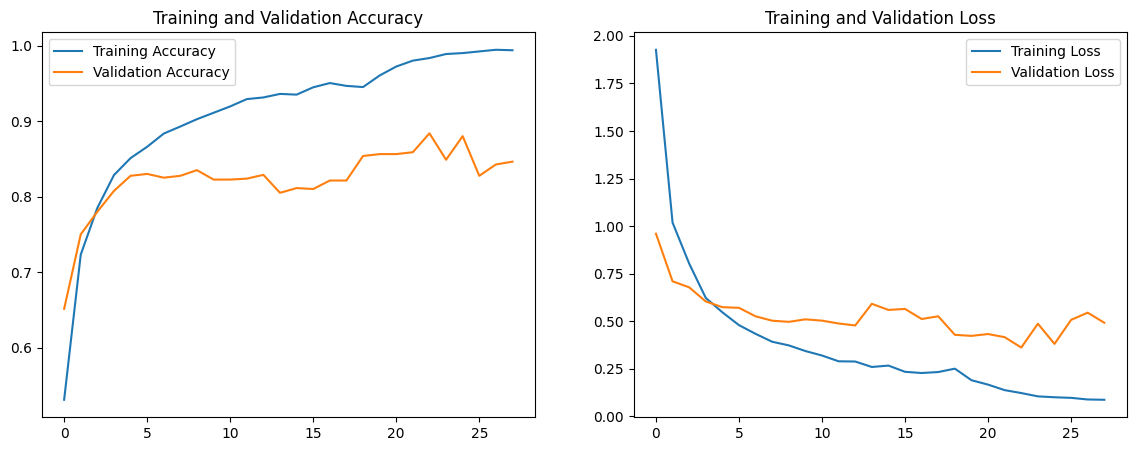

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step


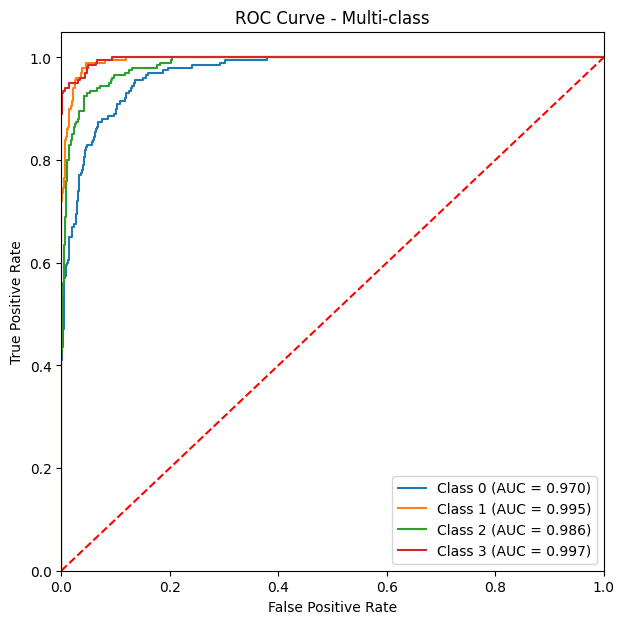

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step
Confusion Matrix:
[[140   0  49  11]
 [ 11 188   1   0]
 [  5   4 189   2]
 [  0   9   1 190]]


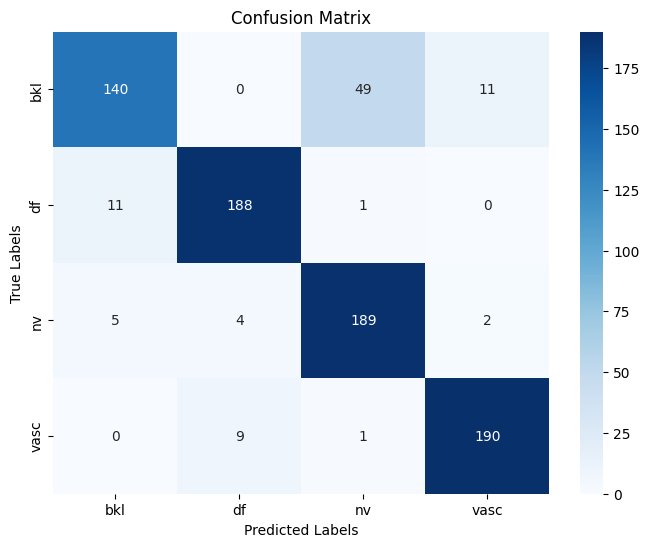

Classification Report:
              precision    recall  f1-score   support

         bkl       0.90      0.70      0.79       200
          df       0.94      0.94      0.94       200
          nv       0.79      0.94      0.86       200
        vasc       0.94      0.95      0.94       200

    accuracy                           0.88       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



In [ ]:

#############################
# 6. PLOT ACCURACY & LOSS
#############################
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#############################
# 7. EVALUATE AUC-ROC
#############################
valid_generator.reset()
y_pred_proba = model.predict(valid_generator)
y_true = valid_generator.classes
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
plt.figure(figsize=(7, 7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.3f})'.format(i, roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

#############################
# 8. CONFUSION MATRIX & CLASSIFICATION REPORT
#############################
valid_generator.reset()
steps = math.ceil(valid_generator.samples / valid_generator.batch_size)
y_pred = model.predict(valid_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)
# Create a list for class labels based on the generator mapping
class_labels = [None] * len(train_generator.class_indices)
for label, idx in train_generator.class_indices.items():
    class_labels[idx] = label
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)
